# ***Examen práctico parical 3***
### Luis Eduardo Jiménez del Muro - 27/04/2025
---

# **Paqueterías**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.float_format', '{:,.4f}'.format)

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.facecolor'] = 'lightgray'

# **Funciones**

## *Funciones para gráficas*

In [2]:
"""
Grafica de calibración
--------------------------------------------------------------------------------------------------------
"""
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3, ls='--')
    plt.legend(fontsize=12, loc='best')
    plt.show()


"""
Roc Curve
--------------------------------------------------------------------------------------------------------
"""
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)

    plt.title('ROC Curve', fontsize=16, fontweight='bold')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Histograma de probabilidades
--------------------------------------------------------------------------------------------------------
"""
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})

    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], stat='density', 
                 color='seagreen', alpha=0.40, kde=True, bins=20, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], stat='density', 
                 color='cadetblue', alpha=0.65, kde=True, bins=20, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades', fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3, ls='--')
    plt.show()


"""
Importance Plot
--------------------------------------------------------------------------------------------------------
"""
def importance_plot(features, importance, type, n_features=10):
    df_importancia = pd.DataFrame({
        'features': features, 
        'importance': importance}).sort_values(by='importance', ascending=True)
    
    plt.barh(df_importancia['features'].tail(n_features), df_importancia['importance'].tail(n_features), 
             color='cadetblue', zorder=2, height=0.4)
    for i, v in enumerate(df_importancia['importance'].tail(n_features)):
        plt.text(v, i, f'{v:.4f}', color='black', fontsize=10)
    plt.title(f'{type}', fontweight='bold', fontsize=16)
    plt.grid(alpha=0.5, ls='--', axis='x', zorder=0)
    plt.show()


"""
Plot Resultados
--------------------------------------------------------------------------------------------------------
"""
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    histograma(probabilidades, y)
    roc_curve_graph(probabilidades, y)

## *Funciones de ajuste de modelos y resultados*

In [3]:
"""
Guardar resultados de los modelos
--------------------------------------------------------------------------------------------------------
"""
def guardar_resultado(nombre_modelo, auc, lista_modelos, lista_auc):
    lista_modelos.append(nombre_modelo)
    lista_auc.append(auc)


"""
Ajuste de un árbol de decisión
--------------------------------------------------------------------------------------------------------
"""
def decision_tree(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('tree', DecisionTreeClassifier(random_state=42)),
    ])
    params = {
        'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        'tree__min_samples_split': [2, 3, 4, 5, 6, 7],
        'tree__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
        'tree__max_features': [None, 'sqrt', 'log2'],
        'tree__criterion': ['gini', 'entropy'],
    }
    grid_tree = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid_tree.fit(X_train, y_train)
    best_model = grid_tree.best_estimator_.named_steps['tree']
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    gain = best_model.feature_importances_

    print(f'Best parameters:')
    display(grid_tree.best_params_)
    return best_model, predicciones, auc, gain



"""
Ajuste de un Random Forest
--------------------------------------------------------------------------------------------------------
"""
def random_forest(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
    ('rf', RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42))
    ])
    params = {
        'rf__max_depth': [1, 2, 5, 8, 10, 15, 50],
        'rf__max_features': ['log2', 'sqrt', len(X_train.columns)*0.7, len(X_train.columns)],
        'rf__min_samples_split': [2, 3, 4, 5, 6, 7]
    }

    rf_grid = GridSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    rf_grid.fit(X_train, y_train)
    best_model = rf_grid.best_estimator_.named_steps['rf']
    predicciones_rf = best_model.predict_proba(X_test)[:, 1]
    auc_rf = roc_auc_score(y_test, predicciones_rf)

    gain = best_model.feature_importances_

    print(f'Best parameters:')
    display(rf_grid.best_params_)
    return best_model, predicciones_rf, auc_rf, gain


"""
Ajuste de XGBoost
--------------------------------------------------------------------------------------------------------
"""
def xgboost(X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': [100_000],
        'max_depth': [1, 2, 5, 10],
        'learning_rate': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.1, 1],
        'tree_method': ['hist'],
        'eval_metric': ['auc']
    }

    model = XGBClassifier(eval_metric='auc', n_jobs=-1, random_state=42,early_stopping_rounds=20)

    xgb_grid = GridSearchCV(estimator=model, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    xgb_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

    best_model = xgb_grid.best_estimator_
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    weight = best_model.get_booster().get_score(importance_type='weight')
    gain = best_model.get_booster().get_score(importance_type='gain')

    print(f'Best parameters:')
    display(xgb_grid.best_params_)
    return best_model, predicciones, auc, weight, gain


"""
Ajuste de LightGBM
--------------------------------------------------------------------------------------------------------
"""
def lgbm(X_train, y_train, X_test, y_test):
    params = {
        'n_estimators': [100_000],
        'max_depth': [1, 2, 3, 5, 8, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1],
        'reg_lambda': [0.01, 0.1, 1],
        'boosting_type': ['gbdt'],
        'metric': ['auc'],
        'feature_fraction': [0.8],
        'subsample': [0.5],
        'num_leaves': [10]
    }

    model = LGBMClassifier(metric='auc', n_jobs=-1, random_state=42, verbosity=-1)

    lgbm_grid = GridSearchCV(estimator=model, n_jobs=-1, cv=5, scoring='roc_auc', param_grid=params)
    lgbm_grid.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
                  callbacks=[early_stopping(50), log_evaluation(100)])

    best_model = lgbm_grid.best_estimator_
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    weight = best_model.booster_.feature_importance(importance_type='split')
    gain = best_model.booster_.feature_importance(importance_type='gain')

    print(f'Best parameters:')
    display(lgbm_grid.best_params_)
    return best_model, predicciones, auc, gain, weight


"""
CatBoost
--------------------------------------------------------------------------------------------------------
"""
def catboost(X_train, y_train, X_test, y_test, cat_cols):
    for col in cat_cols:
        X_train[col] = X_train[col].astype(str).fillna('missing')
        X_test[col] = X_test[col].astype(str).fillna('missing')

    params = {
        'depth': [1, 2, 3, 5, 8, 10],
        'learning_rate': [0.5, 0.8],
        'subsample': [0.5],
        'rsm': [0.8]
    }

    model = CatBoostClassifier(iterations=100_000, eval_metric='AUC', verbose=0, early_stopping_rounds=20, cat_features=cat_cols)

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train,  eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=100)

    best_model = grid_search.best_estimator_
    predicciones = best_model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, predicciones)

    importance = best_model.get_feature_importance(type='FeatureImportance')

    print(f'Best parameters:')
    display(model.get_params())
    return model, predicciones, auc, importance

# **Limpieza de datos**

In [4]:
data = pd.read_csv('data/hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [5]:
data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
is_satisfied                0
dtype: int

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int64 
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int64 
 11  JobInvolvement            1470 non-null   int64 
 12  JobLevel                  1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  MaritalStatus           

In [7]:
data.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBalance                4
YearsAtCompany                37
YearsInCurrentRole            19
YearsSince

In [8]:
data_encoded = pd.get_dummies(data)
data_encoded.columns

Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education',
       'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany',
       'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'is_satisfied', 'Attrition_No', 'Attrition_Yes',
       'BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_H

Las variables que digan "Yes" o "No" habría que eliminar una de ellas, para no tener 2 veces la misma variable. En este caso se elminarán las que digan "No". Tambien se hace lo mismo para el Genero, en este caso dejamos a "Male".

In [9]:
data_encoded = data_encoded.drop(columns=['Attrition_No', 'OverTime_No', 'Gender_Female'])

In [10]:
target = 'Attrition'
target_encoded = 'Attrition_Yes'

numeric_features = [col for col in data.columns if data[col].dtype in ['float64'] or data[col].dtype in ['int64']]
categorical_features = [col for col in data.columns if data[col].dtype not in ['float64'] or data[col].dtype not in ['int64']]

# **1. Crea un árbol de max depth 2 y visualizalo, que puedes concluir?**

## *Separar los datos en Train y Test*

In [11]:
X = data_encoded.drop(columns=[target_encoded])
y = data_encoded[target_encoded]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## *Árbol de max depth 2*

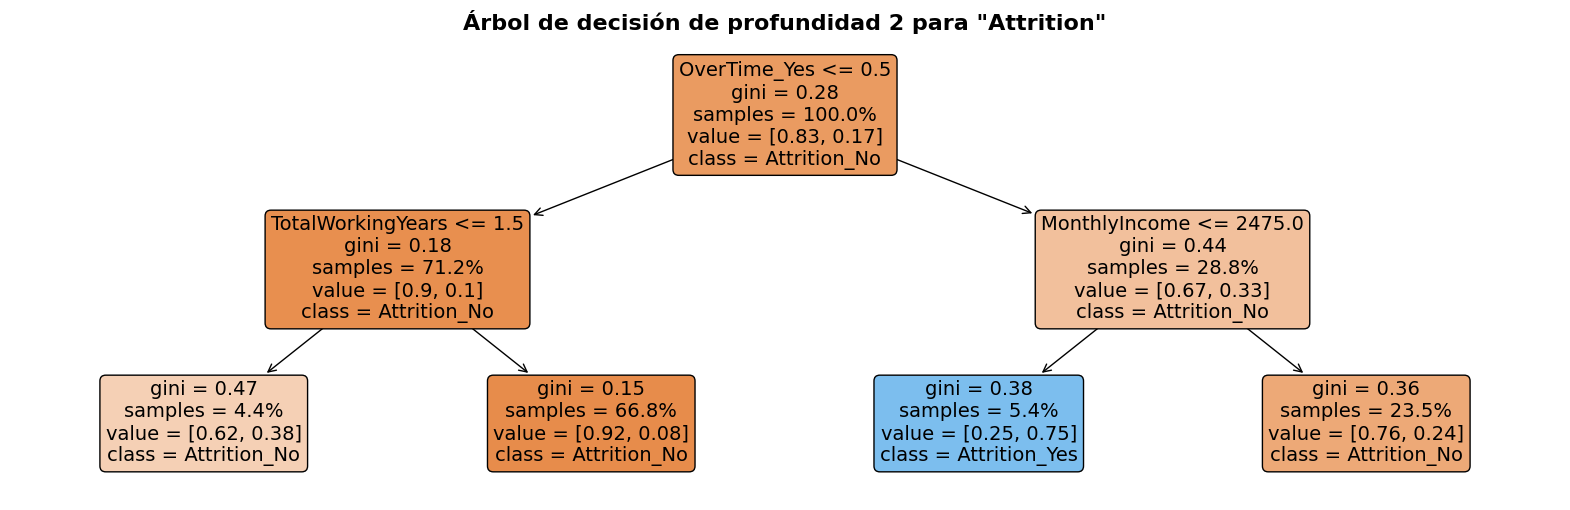

In [12]:
tree_graph = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

plt.figure(figsize=(20, 6), facecolor='white')
plot_tree(tree_graph, feature_names=X.columns, filled=True, rounded=True, proportion=True, fontsize=14, precision=2, class_names=['Attrition_No', 'Attrition_Yes'])
plt.title('Árbol de decisión de profundidad 2 para "Attrition"', fontsize=16, fontweight='bold')
plt.show()

### Conclusión del árbol

Gracias a el árbol anterior, podemos observar que las 3 variables que más impacto tienen para predecir `Attrition` son las horas extras (`OverTime`), los años totales de trabajo (`TotalWorkingYears`) y el salario mensual (`MonthlyIncome`). El corte en 0.5 de `OverTime` separa a los empleados que tienen o no tienen horas extras. En `TotalWorkingYears` el corte que minimiza la impureza 1.5, mientras que en `MonthlyIncome` es 2475.

Gracias a este arbol, podemos ver que la combinación que tiene mayor probabilidad de Attrition es trabajar horas extras y que el salario sea menor o igual a 2475. De todos los trabajadores, el 5.4% tienen esta combinación y de estos, el 75% abandonan. Viendo las probabilidades de abandono en las otras ramas, la siguiente sería no tomar horas extras pero tener pocos años de experiencia, donde el 4.4% de los trabajadores tienen esta combinación y de ellos el 38% abandona.

La combinación de no trabajar horas extras y tener más de 1.5 años de experiencia es la combinación que tiene a la mayoría de los trabajadores, donde 66.8% pertenecen y de ellos el 92% no abandona. Por último trabajar horas extras pero con un salario mayor a 2475 es una combinación a la que pertenecen el 23.5% de los trabajadores, y de ellos, el 76% se quedan.

# **2- Obtén el mejor árbol posible y dime que tan bueno es el modelo**

## *Inicializar listas para guardar los resultados*

In [13]:
resultados_modelos = []
resultados_auc = []

## *Mejor árbol de decisión*

Best parameters:


{'tree__criterion': 'gini',
 'tree__max_depth': 3,
 'tree__max_features': 'sqrt',
 'tree__min_samples_leaf': 5,
 'tree__min_samples_split': 2}

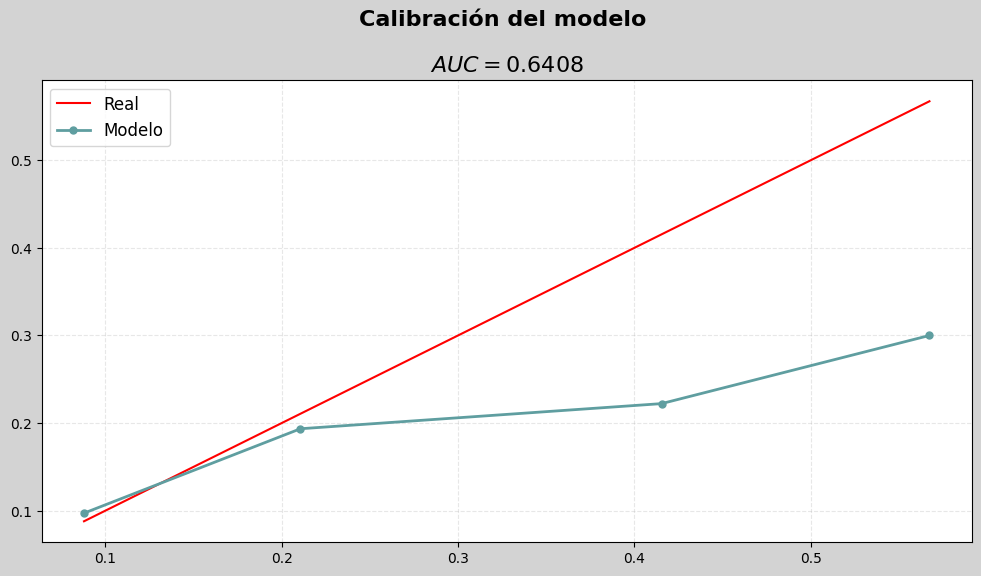

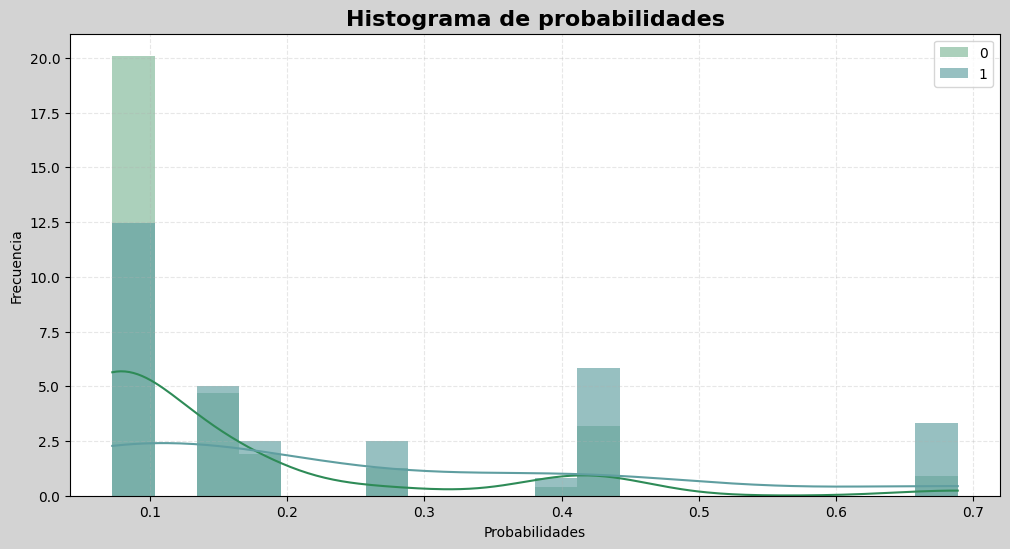

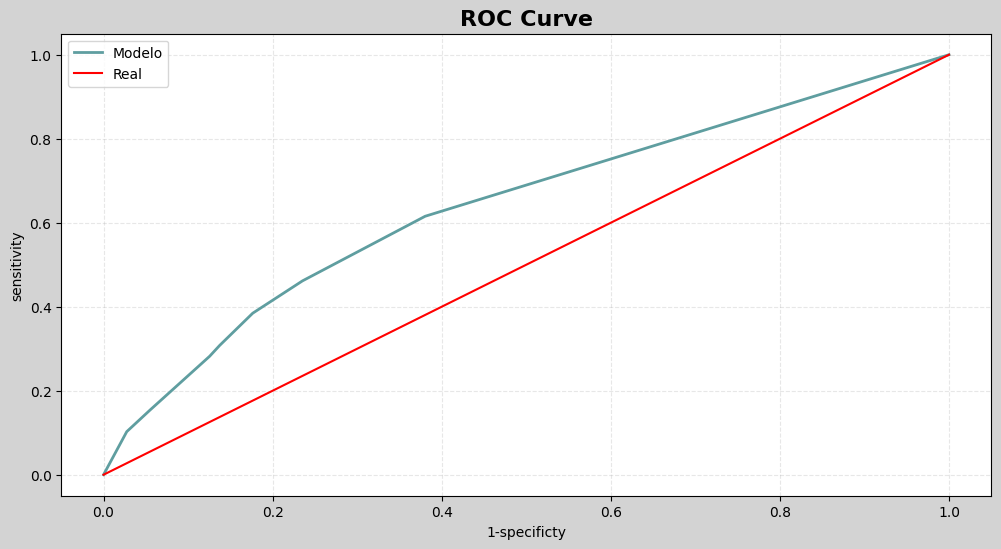

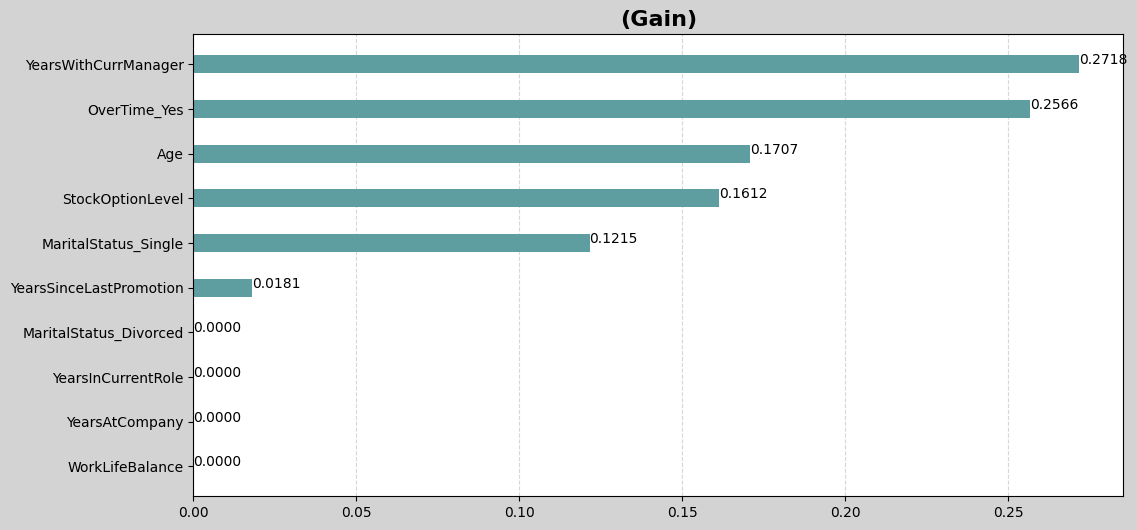

In [14]:
tree, predicciones, auc, gain = decision_tree(X_train, y_train, X_test, y_test)
guardar_resultado('Decision Tree', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, gain, '(Gain)')

### Conclusión del mejor árbol de decisión posible

Despues de realizar el mejor árbol de decisión, nos encontramos con un modelo bastante malo, con un AUC de 0.64. Podemos ver que la calibración del modelo es muy mala y en el histograma que prácticamente no tiene capacidad clasificar al momento de predecir. La curva roc se abre de la diagonal por muy poco, indicando que el modelo está muy cerca de estar al nivel de un modelo que predice de forma aleatoria.

En este caso las variables más importantes para el modelo fueron; `YearsWithCurrManager`, `OverTime_Yes`, `Age`, `StockOptionLevel` y `MaritalStatus_Single`. Curiosamente solamente una de las variables con importancia en este modelo está presente en el árbol de max depth 2 anterior.

# **3. Crea un Random Forest y haz lo mismo, obten el feature importance**

Best parameters:


{'rf__max_depth': 5, 'rf__max_features': 'log2', 'rf__min_samples_split': 6}

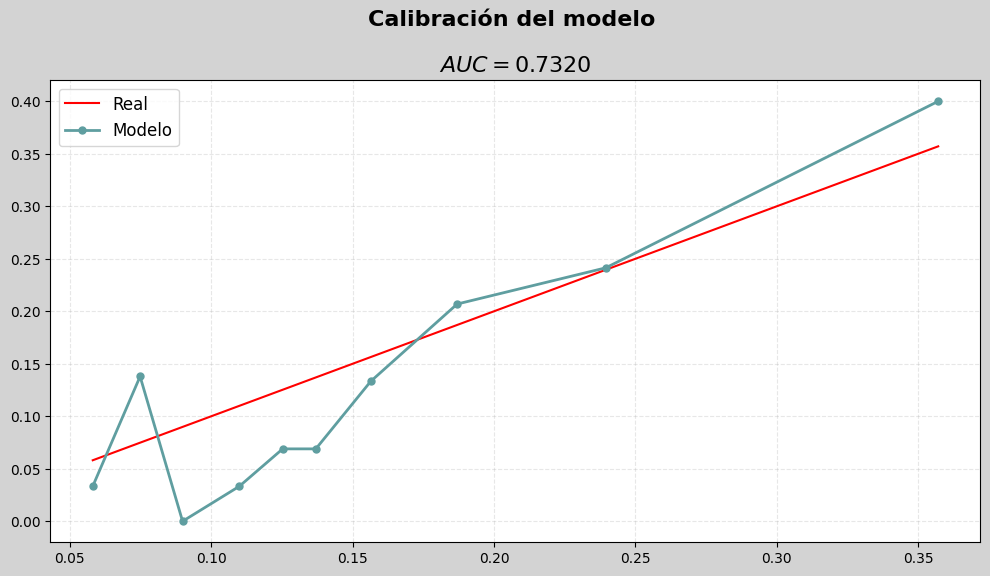

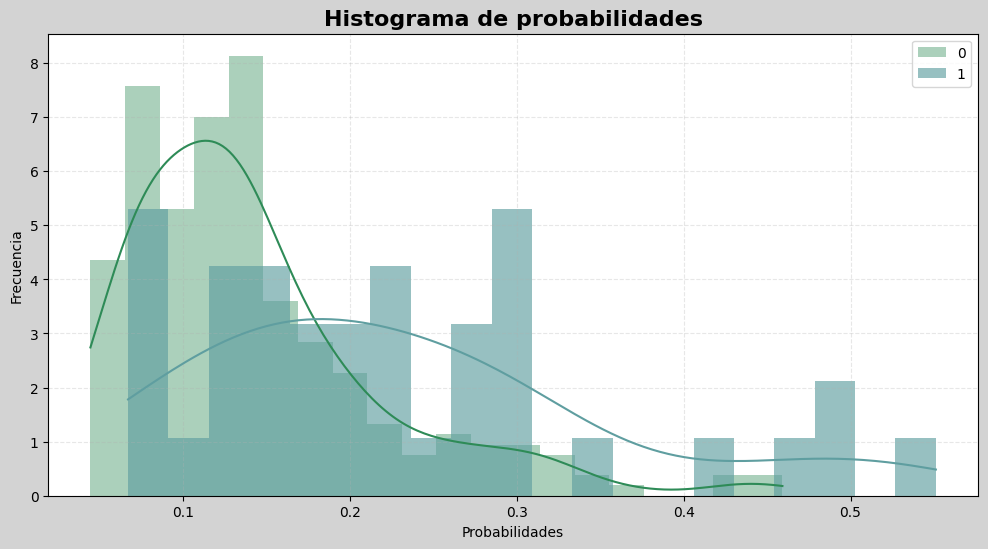

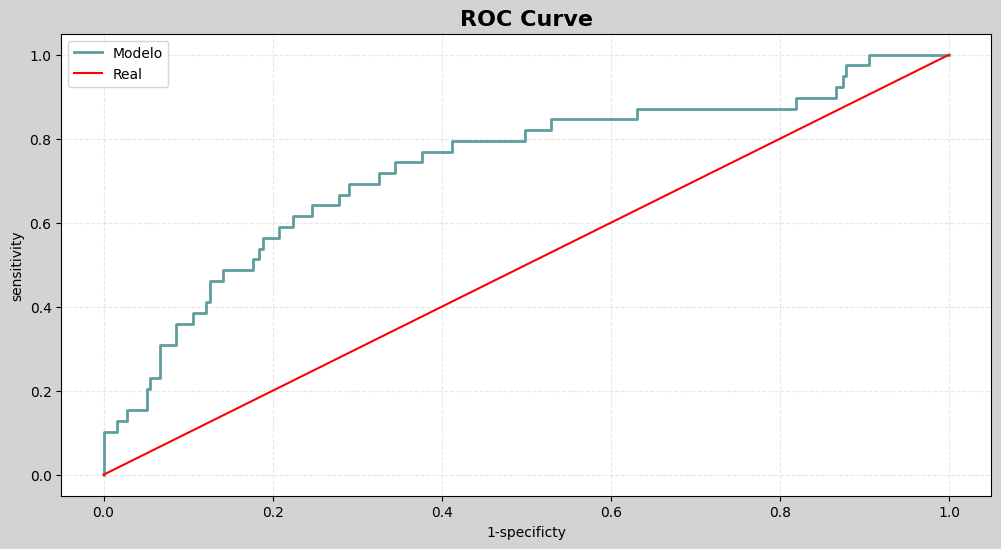

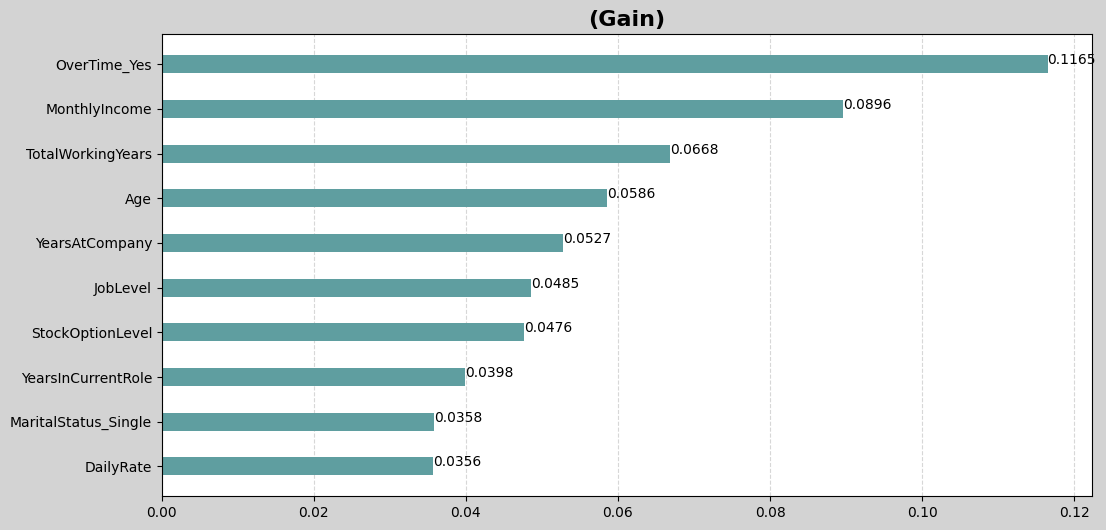

In [15]:
rf, predicciones, auc, gain = random_forest(X_train, y_train, X_test, y_test)
guardar_resultado('Random Forest', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, gain, '(Gain)')

### Conclusión del mejor random forest posible

En este modelo vemos una mejora sustancial comparado al anterior. Se lográ un AUC de 0.7320 y con una calibración mucho mejor. En el histograma vemos que este modelo si logra tener una mejor clasificación en comparación al anterior. La curva roc tiene mucho mayor apertura que la anterior, lo cual indica que nuestro modelo ya es mucho mejor que un modelo de clasificación aleatoria.

En este caso las variables más importantes para el modelo fueron; `OverTime_Yes`, `MonthlyIncome`, `TotalWorkingYears`, `Age` y `YearsAtCompany`. A diferencia del arbol pasado, en este modelo si se encuentran las variables que obtuvimos en el primer árbol de max depth 2.

# **4. Repite el proceso con xgboost**

Best parameters:


{'eval_metric': 'auc',
 'learning_rate': 0.1,
 'max_depth': 1,
 'n_estimators': 100000,
 'reg_lambda': 0.01,
 'tree_method': 'hist'}

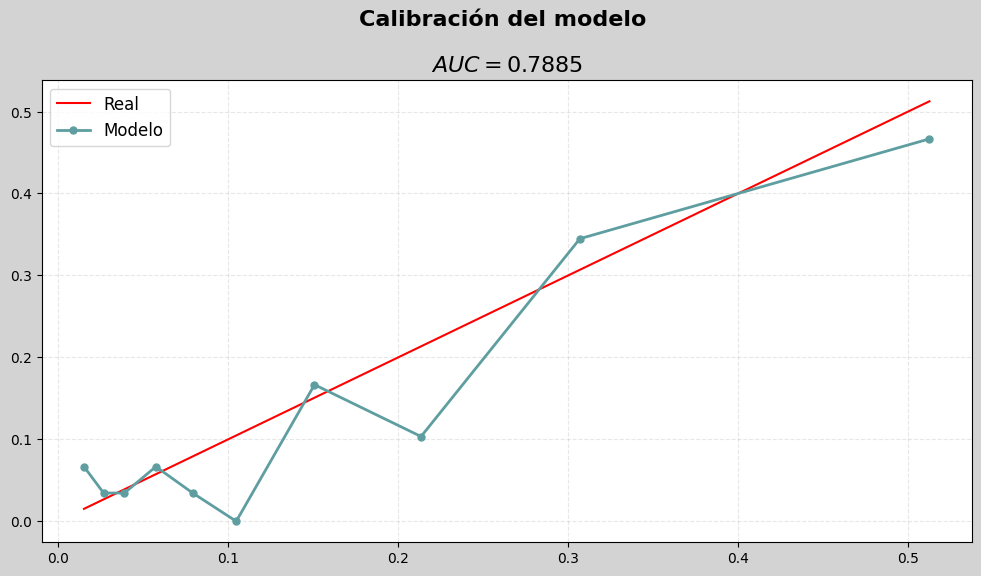

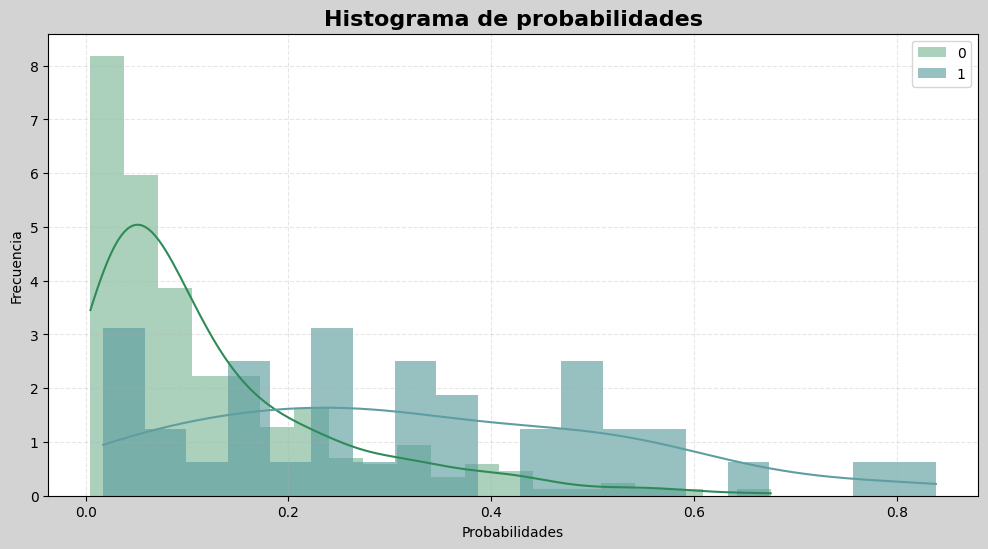

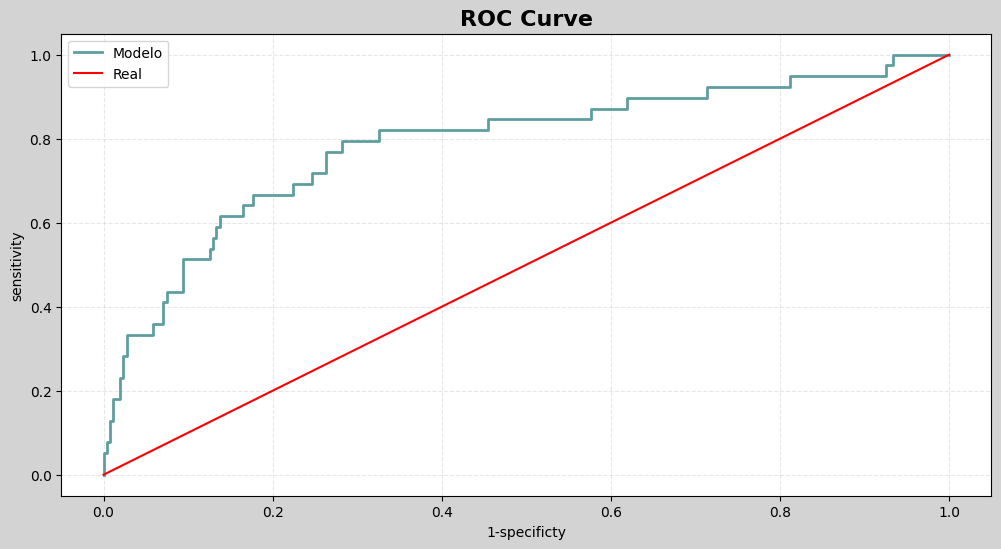

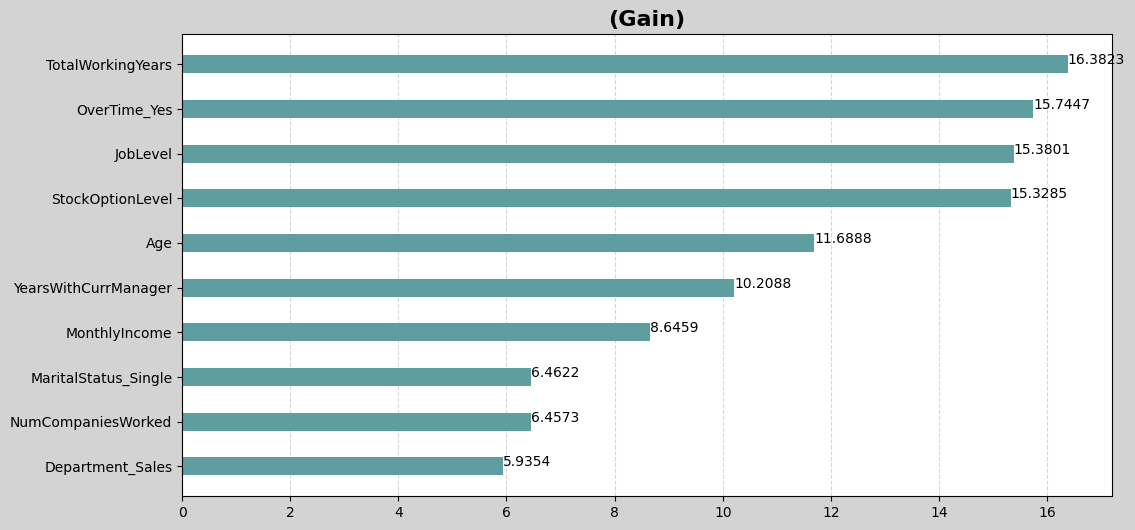

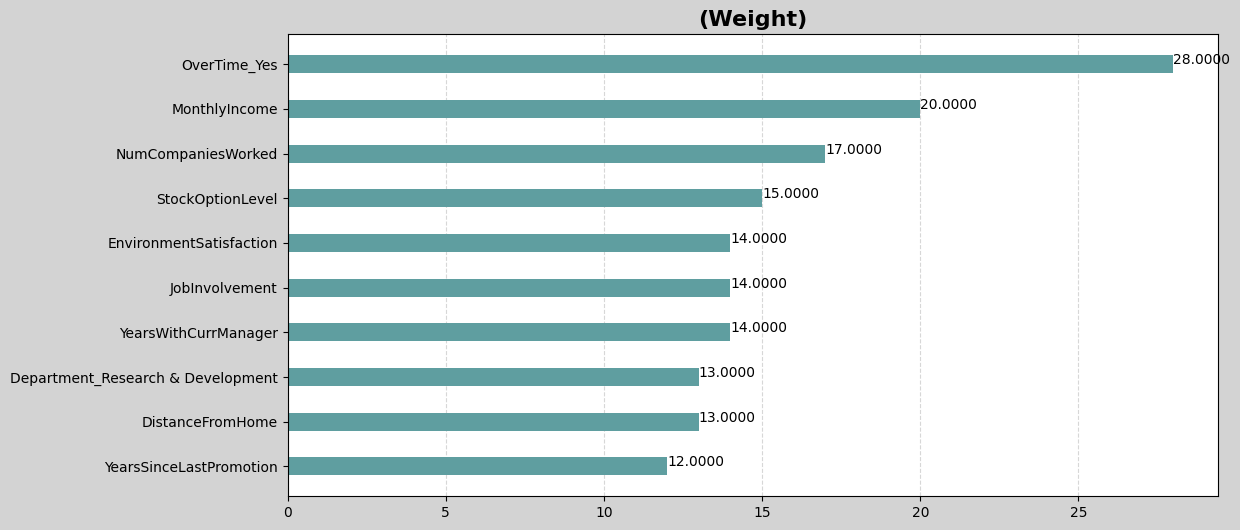

In [16]:
xgboost_model, predicciones, auc, weight, gain = xgboost(X_train, y_train, X_test, y_test)
guardar_resultado('XGBoost', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(gain.keys(), gain.values(), '(Gain)')
importance_plot(weight.keys(), weight.values(), '(Weight)')

### Conclusión del mejor XGBoost

Nuevamente obsevarbamos una mejora llegando a un AUC de 0.7885 y una calibración más precisa. Tambien podemos observar una grán mejora en la capacidad de clasificación en el histograma de probabilidades así como tambien un mayor area en la curva Roc.

En cuanto a la importancia Gain las variables mas importantes para el modelo fueron; `TotalWorkingYears`, `OverTime_Yes`, `JobLevel`, `StockOptionLevel` y `Age`. Por otro lado, para la importancia tipo Weight, las variables más importantes fueron; `OverTime_Yes`, `MonthlyIncome`, `NumCompaniesWorked`, `StockOptionLevel` y `EnvironmentSatisfaction`.

# **5. Repite el proceso con lightgbm**

Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.868821	valid_1's auc: 0.757466
[200]	training's auc: 0.891027	valid_1's auc: 0.780694
[300]	training's auc: 0.902274	valid_1's auc: 0.786626
[400]	training's auc: 0.910501	valid_1's auc: 0.792257
[500]	training's auc: 0.916734	valid_1's auc: 0.794268
[600]	training's auc: 0.921686	valid_1's auc: 0.795676
Early stopping, best iteration is:
[564]	training's auc: 0.920044	valid_1's auc: 0.797185
Best parameters:


{'boosting_type': 'gbdt',
 'feature_fraction': 0.8,
 'learning_rate': 0.1,
 'max_depth': 1,
 'metric': 'auc',
 'n_estimators': 100000,
 'num_leaves': 10,
 'reg_lambda': 0.01,
 'subsample': 0.5}

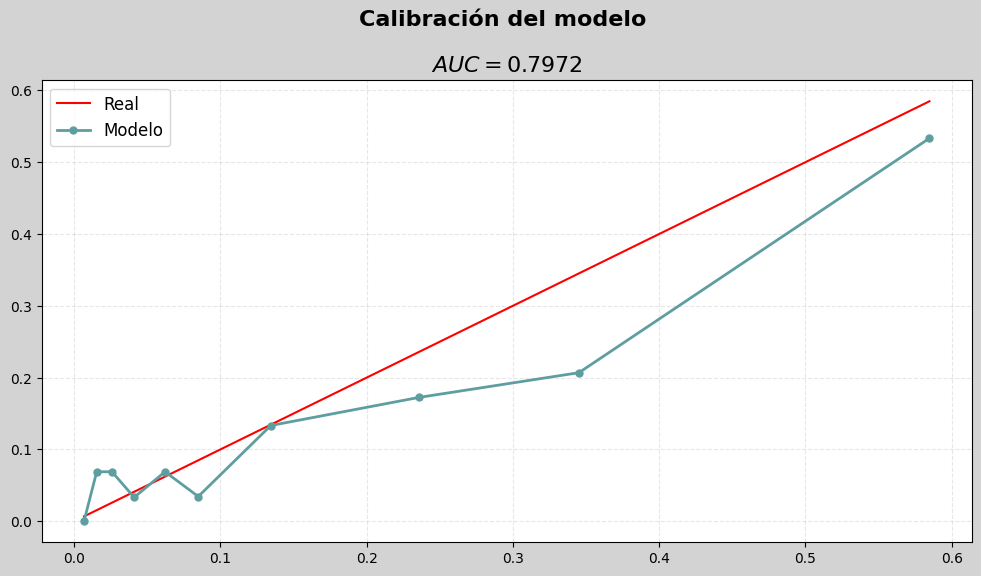

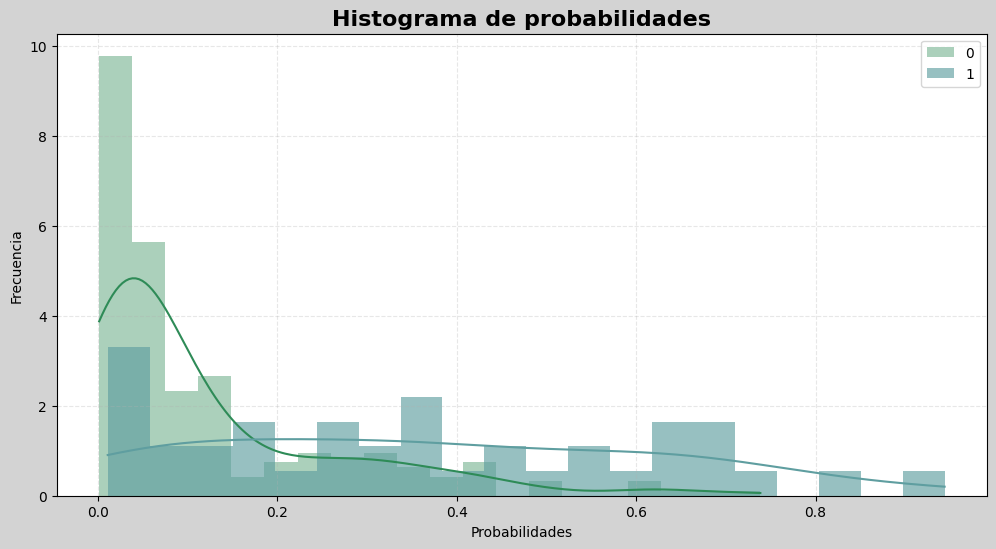

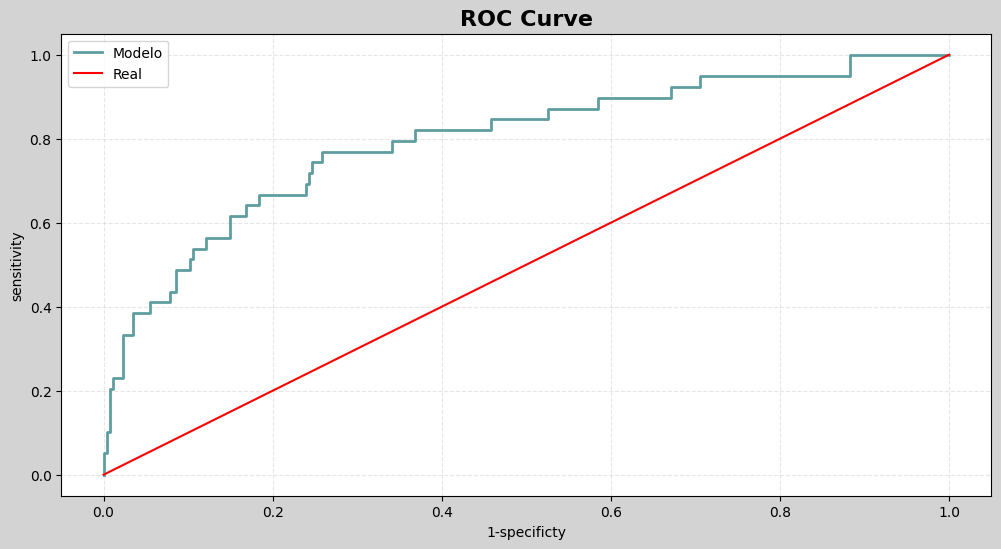

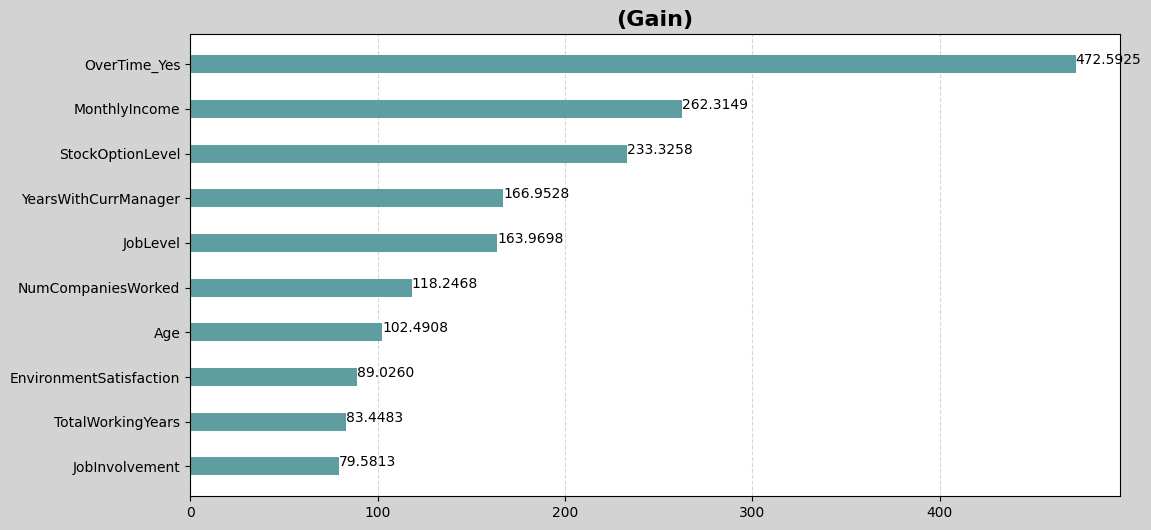

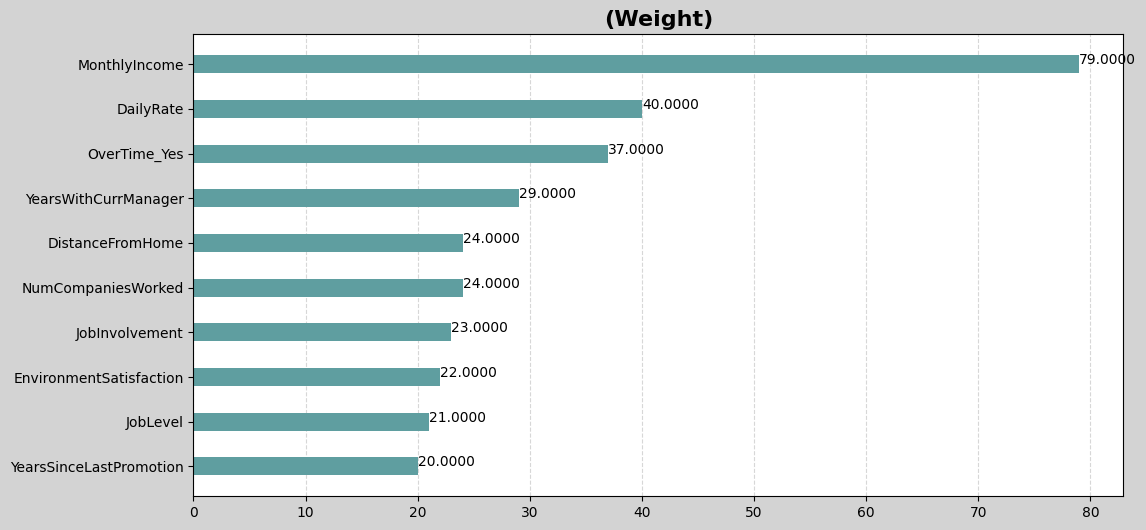

In [17]:
ligbm_model, predicciones, auc, gain, weight = lgbm(X_train, y_train, X_test, y_test)
guardar_resultado('LightGBM', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, gain, '(Gain)')
importance_plot(X_train.columns, weight, '(Weight)')

### Conclusión del mejor LightGBM

Se percibe una mejora a comparación de XGBoost aunque no es tan importante como las anteriores. Nuevamente tenemos un modelo mejor calibrado, con mejor capacidad de clasificación y con mayor area en la curva Roc.

En cuanto a la importancia Gain las variables mas importantes para el modelo fueron; `OverTime_Yes`, `MonthlyIncome`, `StockOptionLevel`, `YearsWithCurrManager` y `JobLevel`. Por otro lado, para la importancia tipo Weight, las variables más importantes fueron; `MonthlyIncome`, `DailyRate`, `OverTime_Yes`, `YearsWithCurrManager` y `DistanceFromHome`.

# **6. Repite el proceso con catboost**

Best parameters:


{'iterations': 100000,
 'verbose': 0,
 'eval_metric': 'AUC',
 'early_stopping_rounds': 20,
 'cat_features': ['BusinessTravel',
  'Department',
  'EducationField',
  'Gender',
  'JobRole',
  'MaritalStatus',
  'Over18',
  'OverTime',
  'is_satisfied']}

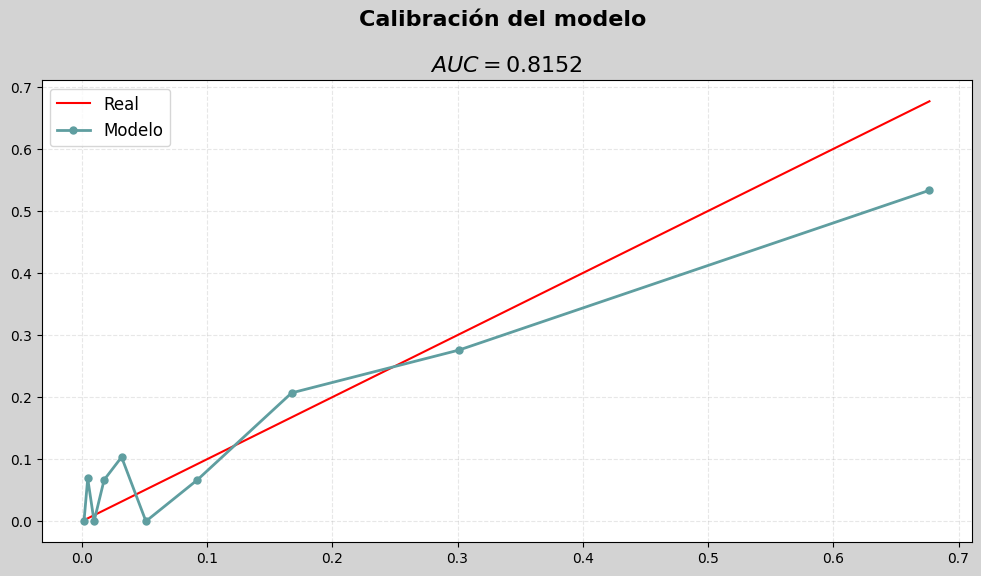

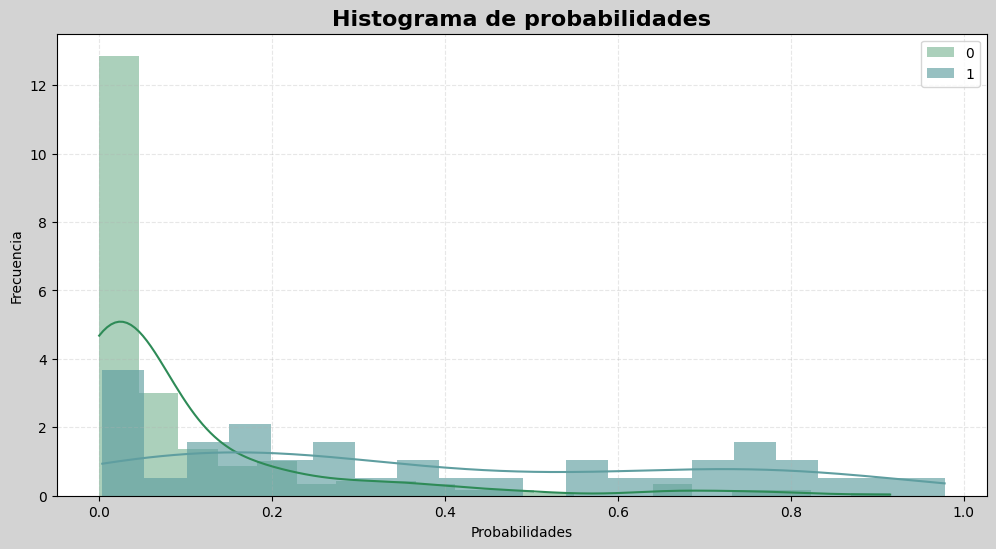

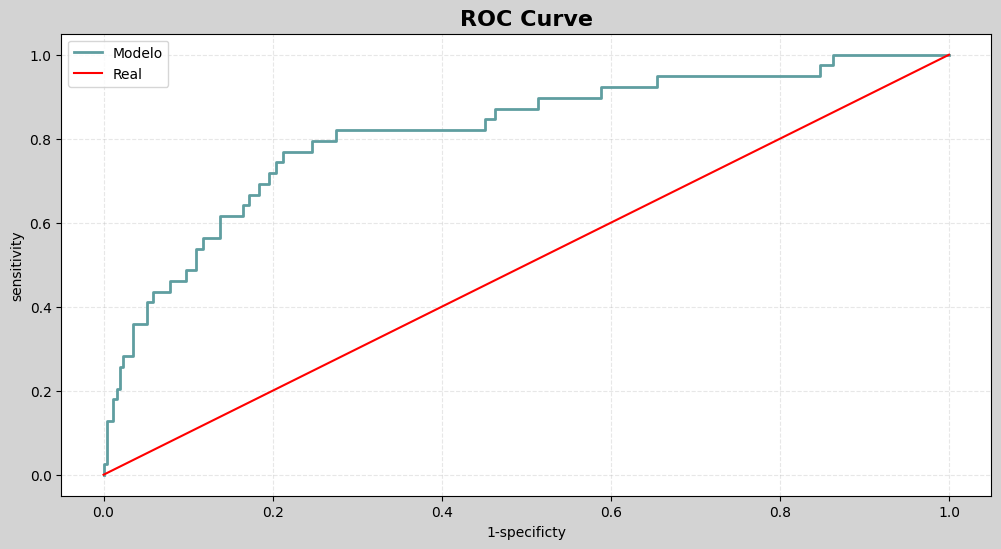

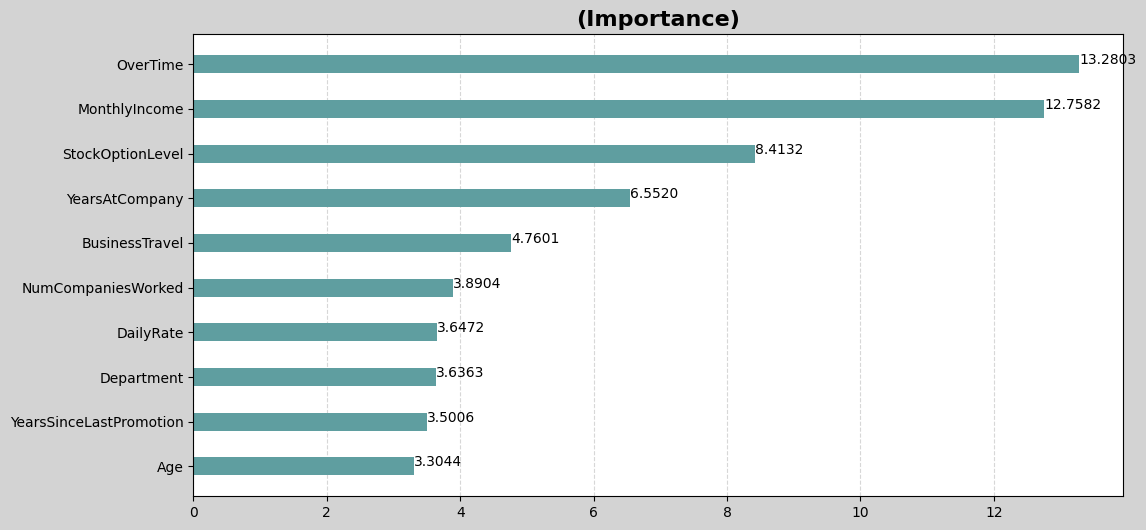

In [ ]:
catboost_data = data.copy()
X = catboost_data.drop(columns=[target])
y = data_encoded[target_encoded] # Se toma el mismo target de los modelos encoded para tener el mismo True/False

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cat_cols = [col for col in X_train.columns if col not in numeric_features]

for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

catboost_model, predicciones, auc, importance = catboost(X_train, y_train, X_test, y_test, cat_cols)
guardar_resultado('CatBoost', auc, resultados_modelos, resultados_auc)
plot_results(predicciones, y_test, 10)
importance_plot(X_train.columns, importance, '(Importance)')

### Conclusión del mejor CatBoost

Nuevamente aunque no por mucho, se percibe una pequeña mejora a comparación del modelo pasado, logrando un AUC de 0.8152, una mejor calibración, mejor capacidad de clasificación y un aumento en el area de la curva roc.

En cuanto a la importancia de las variables, las más importantes fueron; `OverTime`, `MonthlyIncome`, `StockOptionLevel`, `YearsAtCompany` y `BusinessTravel`.

# **¿Cuál fue el mejor modelo? ¿Qué puedes concluir?**

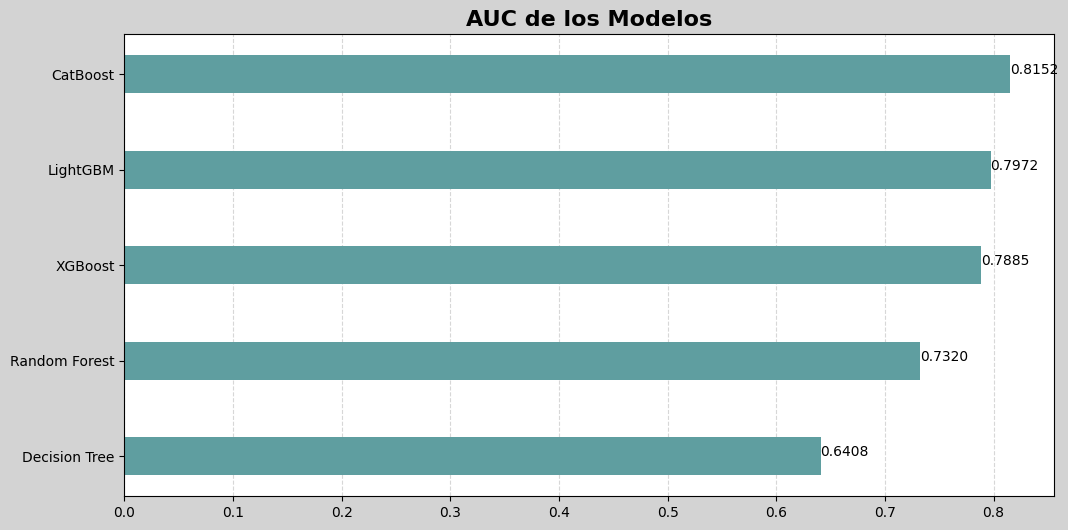

In [19]:
importance_plot(resultados_modelos, resultados_auc, 'AUC de los Modelos')

Luego de probar los diferentes modelos, en términos de AUC, el mejor modelo fue CatBoost con 0.8152. No obstante, se observó un desempeño muy parecido entre los modelos de Boosting. En este caso, el árbol de decisión y random forest tuvieron un desempeño mucho peor. Además se observó que los 3 modelos de boosting lograron una muy buena capacidad de clasificación en los histogramas de probabilidad.

Hay que recordar que CatBoost es especialista en variables categóricas, y que en este dataset se tienen muchas variables categóricas, por lo que, esto hizo que destacara ante los otros modelos. A lo largo de todos los modelos, observamos que muchas variables se repiten en las importancias. En general podríamos decir que las variables mas importantes para predecir el attrition de los trabajadores son:

+ `OverTime`
+ `MonthlyIncome`
+ `StockOptionLevel`

Y las variables más importantes para CatBoost son:

+ `OverTime` 
+ `MonthlyIncome` 
+ `StockOptionLevel` 
+ `YearsAtCompany` 
+ `BusinessTravel`

Por último, me gustaría mencionar los tiempos que tardan en correr cada modelo, ya que, esto podría ser un factor para decidir. Tomando en cuenta solo los modelos de Boosting, el más rápido fue XGBoost, luego LightGBM y el más tardado fue CatBoost con los siguientes tiempos:

+ **XGBoost**: 7 seg.
+ **LightGBM**: 1 min 33 seg.
+ **CatBoost**: 1 min 47 seg.

Entonces si se decide por un modelo robusto y consistente pero sobre todo que sea rápido, XGBoost es muy buena opción, sin embargo, si el tiempo y el costo computacional no es problema, entonces CatBoost es el ganador. 